In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
import seaborn as sns
#from sklearn import preprocessing, svm
#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
#from scipy.special import boxcox,inv_boxcox

In [2]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [ ]:
"""
stand_location = pd.read_csv('metaData_taxistandsID_name_GPSlocation.csv')#I modify the file to add a row of 0, representing no value
#stand_location.loc[len(stand_location)] = [0, None, None, None]
stand_location.head()
"""

In [3]:
df_tr = pd.read_csv('train.csv') #need to split train_data into validation set later
print(df_tr.shape)

(1710670, 9)


In [4]:
#We delete the rows with missing data
df_tr = df_tr.drop(df_tr[df_tr.MISSING_DATA == True].index)
print(df_tr.shape)

(1710660, 9)


In [ ]:
df_tr.head()

In [5]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [ ]:
"""
Longitudes = []
Latitudes = []

print(df_tr['POLYLINE'].loc[762].strip('][').split('],['))
print(df_tr['POLYLINE'].loc[762])

for idx, row in df_tr.iterrows():
    Positions = df_tr['POLYLINE'].loc[idx].strip('][').split('],[')
    if Positions!=['']:
        for position in Positions:
            Longitudes.append(float(position.split(',')[0]))
            Latitudes.append(float(position.split(',')[1]))

np.save('Longitudes.npy',Longitudes)
np.save('Latitudes.npy',Latitudes)
"""


In [6]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,7,1,0,0
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,2013,7,1,0,0
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,2013,7,1,0,0
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,7,1,0,0
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,7,1,0,0


In [7]:
mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
median = df_tr["LEN"].median()
print(f"{mean=} {median=} {std=}")

mean=716.4222405387394 median=600.0 std=684.7289510994718


In [ ]:
# Sample submission file that is given on kaggle
df_sample = pd.read_csv("sampleSubmission.csv")

df_sample["TRAVEL_TIME"] = 716.43

# mean(716.43) -> 792.73593
# median(600) -> 784.74219
df_sample.to_csv("my_pred.csv", index=None)

In [ ]:
# First n samples to analyze. Set to -1 to use all data
end = -1

outlier_threshold = 3

# "Choose all data, where the trip length is less than 3 standard deviations away from the mean"
# This is to remove outliers. Otherwise, our plots would look very squished (since there are some
# VERRRRRY long taxi trips in the dataset)
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

# Because our y-values only take on multiples of 15, we want just enough buckets in a histogram
# such that each buckets counts one value's frequency. (e.x. one bucket counts how many 15s trips, 
# how many 30s trips, etc. )
buckets = (int(mean + outlier_threshold * std) // 15)

print(f"Using: {len(df_trimmed)}/{len(df_tr)}")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,14))

# Now, we visualize some features that we think might be useful
for idx, v in enumerate(["YR", "MON", "DAY", "HR", "WK", "ORIGIN_STAND"]):
  # idx // 3 = row, idx % 3 = column
  ax = axs[idx // 3, idx % 3]
  
  # Remove any rows with invalid values
  df_subset = df_trimmed.dropna(subset=v)
  
  # Create a histogram. Look up the documentation for more details
  ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))
  
  # Some stylistic things to make the graphs look nice
  ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
  ax.set_facecolor("black")
  ax.set_ylabel("seconds", fontsize=18)
  ax.set_title(f"Feature: {v}", fontsize=20)
    

In [ ]:
plt.figure(figsize=(10,10))
for v in [0, 5, 11, 17, 23]:
  # Filter data where the HR matches v
  hourly_data = df_trimmed[df_trimmed["HR"] == v]["LEN"]
  histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
  histogram = histogram / len(hourly_data)
  # The center is the left_bound and right_bound of a bucket
  bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
  plt.plot(bin_centers, histogram, label=f"HR={v}")
plt.legend();

In [7]:
#It seems that all data's day types are A, so we remove the last column; we also delete missing_data column as it is not useful
#We remove ORIGIN_CALL because there are 57125 distinct values, which is not useful for categorical input
#Fill NaN values with 0
df_tr = df_tr.drop(['MISSING_DATA','DAY_TYPE','ORIGIN_CALL','POLYLINE','TRIP_ID','TIMESTAMP'],axis=1)
df_tr.head()
#def draw_corr_picture(X):
#    corrmat = X.corr()
#    plt.subplots(figsize=(12,12))
#    sns.heatmap(corrmat,vmax=0.9,square=True,cmap='Blues')
#    plt.show()

#draw_corr_picture(all_features)

,CALL_TYPE,ORIGIN_STAND,TAXI_ID,LEN,YR,MON,DAY,HR,WK
0,C,NaN,20000589,330,2013,7,1,0,0
1,B,7.0,20000596,270,2013,7,1,0,0
2,C,NaN,20000320,960,2013,7,1,0,0
3,C,NaN,20000520,630,2013,7,1,0,0
4,C,NaN,20000337,420,2013,7,1,0,0


In [ ]:
"""all_features['ORIGIN_STAND'] = all_features['ORIGIN_STAND'].fillna(0)
latitude = []
longitude = []
for idx, row in all_features.iterrows():
    stand = all_features.loc[idx, 'ORIGIN_STAND']
    latitude.append(stand_location.loc[stand, 'Latitude'])
    longitude.append(stand_location.loc[stand, 'Longitude'])
all_features.head()
all_features['ORIGIN_LATITUDE'] = latitude
all_features['ORIGIN_LONGITUDE'] = longitude
all_features.head()"""

In [8]:
#standardize numeric entry values, parse taxi-id into strings
df_tr['TAXI_ID'] = df_tr['TAXI_ID'].astype(str)
df_tr['ORIGIN_STAND'] = df_tr['ORIGIN_STAND'].astype(str)
#There are overall 50000 different callers, so it's impossible to create one-hot for them

In [9]:
#create one-hot columns for discrete values
df_tr = pd.get_dummies(df_tr, dummy_na=False)
df_tr.head()

,LEN,YR,MON,DAY,HR,WK,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_STAND_1.0,...,TAXI_ID_20000903,TAXI_ID_20000904,TAXI_ID_20000911,TAXI_ID_20000931,TAXI_ID_20000940,TAXI_ID_20000941,TAXI_ID_20000969,TAXI_ID_20000970,TAXI_ID_20000980,TAXI_ID_20000981
0,330,2013,7,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,270,2013,7,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,960,2013,7,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,630,2013,7,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,420,2013,7,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_tr.head()
#df_tr.to_csv('df_tr.csv')

In [ ]:
#df_tr = pd.read_csv('df_tr.csv')
#df_tr.head()

In [10]:
train_labels = torch.tensor(df_tr['LEN'].values, dtype=torch.int32)
df_tr=df_tr.drop(['LEN'],axis=1)
train_features = torch.tensor(df_tr.values, dtype=torch.int32)

In [11]:
print(train_labels.shape)
print(train_features.shape)

torch.Size([1710660])
torch.Size([1710660, 520])


In [12]:
del df_tr

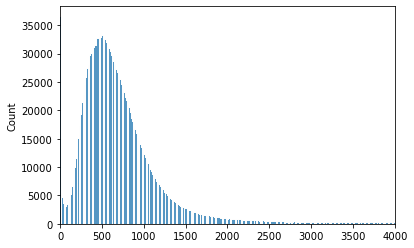

In [13]:
sns.histplot(data=train_labels)
plt.xlim(0,4000)
plt.show()

In [14]:
torch.save(train_features,'train_features.pt')
torch.save(train_labels,'train_labels.pt')

In [ ]:
#Tasks and something to think about

#I ignored callers' id and make taxi-id a categorical feature(which creates 400 columns and seems not efficient), there may be better ways to do that

#building model

#Use sklearn for something like gradient boosting or random forest, manually build a neural network

#Model Selection: Gradient Boosting,Random Forest,Extra Randomized Trees, SVM, Linear Regression, Logistic Regression, Neural Networks

#Try Ensemble Learning, maybe stacking different models